In [96]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay
from tabpfn import TabPFNClassifier 
from ensemble_tabpfn import EnsembleTabPFN
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from ensemble_tabpfn import EnsembleTabPFN
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [97]:
zero_noise = pd.read_csv("data/zero_noise.csv")
low_noise = pd.read_csv("data/low_noise.csv")
high_noise = pd.read_csv("data/high_noise.csv")
low_noise.drop(columns=["data_type"], inplace=True)
high_noise.drop(columns=["data_type"], inplace=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
def encode(v, class_values):
    return class_values.index(v)

def encode_target(v, class_values):
    return class_values.index(v)

class_values_zero = list(zero_noise.era.unique())
class_values_zero_target_5 = list(zero_noise.target_5_val.unique())
class_values_zero_target_10 = list(zero_noise.target_10_val.unique())
zero_noise["era_label"] = zero_noise["era"].apply(encode, args=(class_values_zero,))
zero_noise["target_5_val_label"] = zero_noise["target_5_val"].apply(encode_target, args=(class_values_zero_target_5,))
zero_noise["target_10_val_label"] = zero_noise["target_10_val"].apply(encode_target, args=(class_values_zero_target_10,))

class_values_low = list(low_noise.era.unique())
class_values_low_target_5 = list(low_noise.target_5_val.unique())
class_values_low_target_10 = list(low_noise.target_10_val.unique())
low_noise["era_label"] = low_noise["era"].apply(encode, args=(class_values_low,))
low_noise["target_5_val_label"] = low_noise["target_5_val"].apply(encode_target, args=(class_values_low_target_5,))
low_noise["target_10_val_label"] = low_noise["target_10_val"].apply(encode_target, args=(class_values_low_target_10,))

class_values_high = list(high_noise.era.unique())
class_values_high_target_5 = list(high_noise.target_5_val.unique())
class_values_high_target_10 = list(high_noise.target_10_val.unique())
high_noise["era_label"] = high_noise["era"].apply(encode, args=(class_values_high,))
high_noise["target_5_val_label"] = high_noise["target_5_val"].apply(encode_target, args=(class_values_high_target_5,))
high_noise["target_10_val_label"] = high_noise["target_10_val"].apply(encode_target, args=(class_values_high_target_10,))

dataset = high_noise
target_column = "target_5_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [110]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.long),
        )

In [114]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
# dataset = dataset.sort_values(by="row_num")
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

# train_dataset = train_dataset.sort_values(by="row_num")
# val_dataset = val_dataset.sort_values(by="row_num")
# test_dataset = test_dataset.sort_values(by="row_num")

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [64]:
# data = low_noise.sample(frac=1).reset_index(drop=True)
# data = data.sort_values(by=["row_num", "day", "era"])
# X = data.iloc[:20, :-5]
# X

In [115]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [116]:
evals = []
models = []
# clf = EnsembleTabPFN()
classifier = TabPFNClassifier(device=device, N_ensemble_configurations=32)
probs=[]
probas_list=[]
for (feature, label) in train_dataloader:
    feature = feature.numpy()
    label = label.numpy()
    classifier.fit(feature, label)
    y_eval,y_pred = classifier.predict(feature, return_winning_probability=True)
    probas = classifier.predict_proba(feature)
    evals.append(y_eval)
    probs.append(y_pred)
    probas_list.append(probas)
    models.append(classifier)
    break

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packa

In [117]:
# predictions=[]
# for model in tqdm(models):
#     y_eval, y_pred = model.predict(x, return_winning_probability=True)
#     predictions.append(y_eval)

accuracies = []
predictions = []
for (feature, label) in tqdm(test_dataloader):
    feature = feature.numpy()
    label = label.numpy()
    y_eval, y_pred = models[0].predict(feature, return_winning_probability=True)
    accuracies.append(accuracy_score(label, y_eval))
    predictions.append(y_pred)

  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packa

In [118]:
print(f"Accuracy: {np.mean(accuracies)}")

Accuracy: 0.5327739130434783


In [120]:
def plot(val, mode):
    # if mode == "accuracy":
    #     for i in range(len(train)):
    #         train[i] = train[i].cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    # plt.plot(train, label=f"Training {mode}")
    plt.plot(val, label=f"Validation {mode}")
    plt.title(f"Training and Validation {mode} Curve")

    plt.xlabel("Epochs")
    plt.ylabel(f"{mode}")
    plt.legend()
    plt.show()

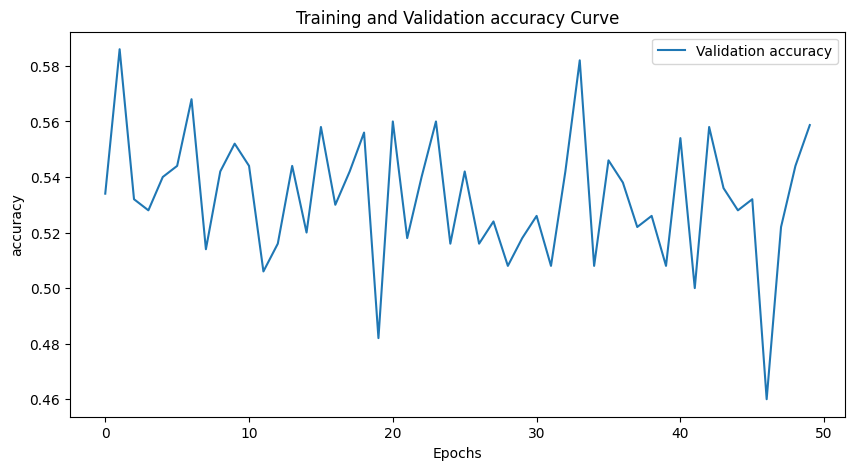

In [121]:
plot(accuracies, "accuracy")